In [1]:
from dataset import OpenImageDataset

In [101]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [3]:
from transformers import CLIPTokenizer

clip_tokenizer = CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="tokenizer",
)

In [4]:
split = "train"

dataset = OpenImageDataset(
    split=f"{split}",
    load_cache=True,
    # debug=True,
    # text_transform=lambda x: x,
    clip_tokenizer=clip_tokenizer,
    # simple_prompt=True
)

All labels: 291905


In [9]:
# browse a random sample
import random

i = random.randint(0, len(dataset))

example = dataset[i]

In [6]:
example.keys()

dict_keys(['image', 'input_image', 'target_image', 'bbox_image', 'bbox_input_image', 'bbox_target_image', 'caption', 'class_name', 'input_ids', 'ctx_begin_pos', 'input_ids_label', 'ctx_begin_pos_label', 'image_id', 'bbox', 'row'])

In [299]:
print(example["class_name"])

hat


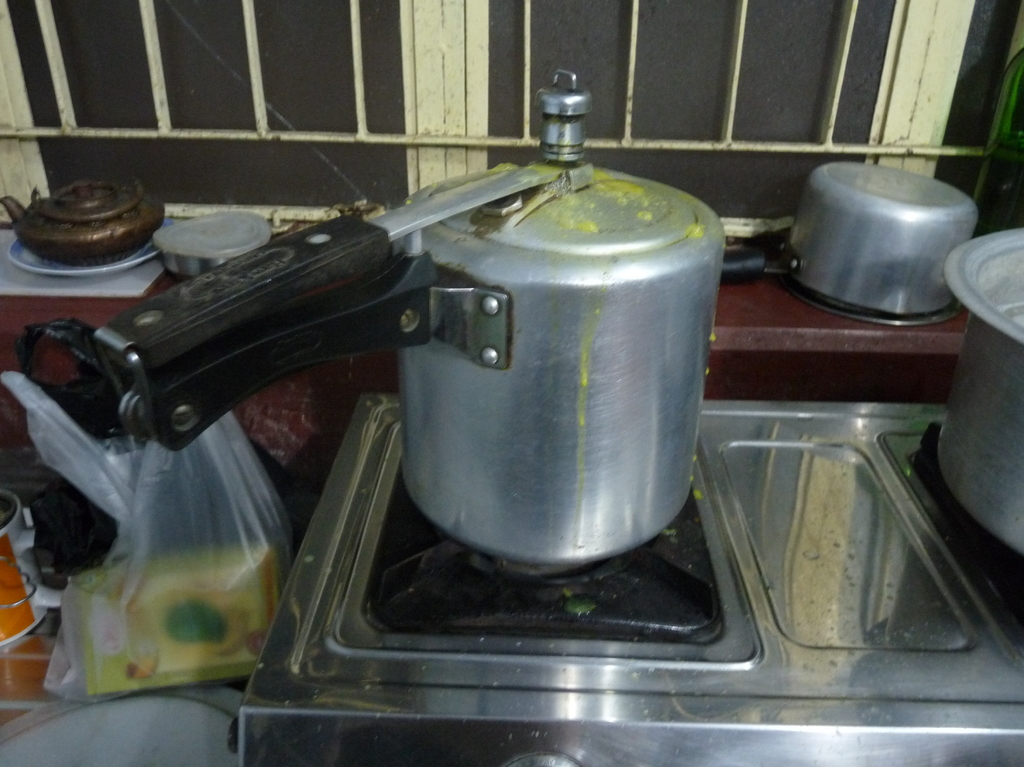

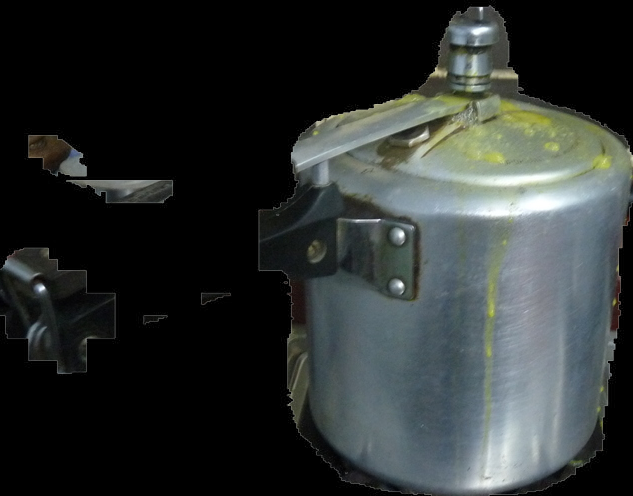

In [10]:
display(example["image"])
display(example["bbox_image"])
# display(example["bbox_mask"])

In [7]:
print(type(example["bbox_image"]))
print(type(example["bbox_mask"]))

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


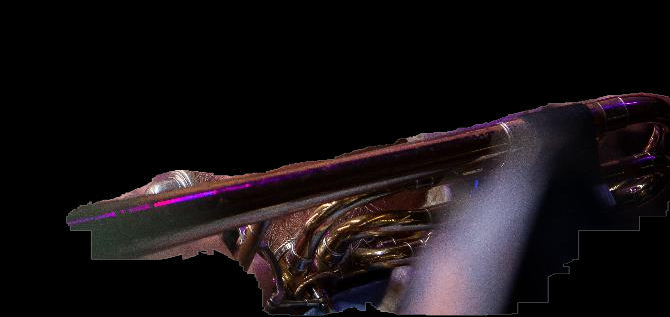

In [11]:
from PIL import Image
masked = Image.composite(example["bbox_image"], example["bbox_mask"], example["bbox_mask"].convert("L"))
display(masked)

In [301]:
from rembg import remove
output = remove(example["bbox_image"], only_mask=True, post_process_mask=True)

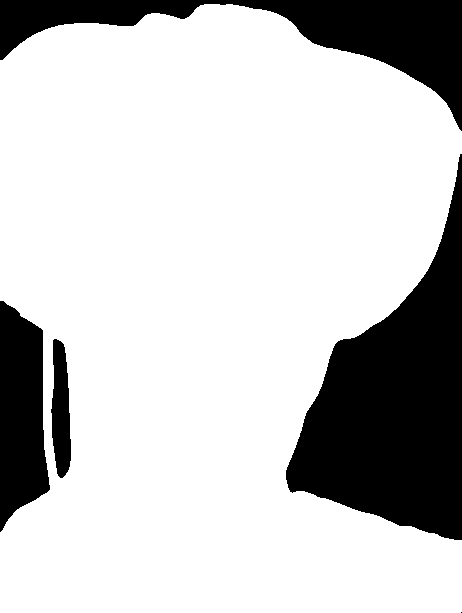

In [302]:
display(output)

In [303]:
prompts = [example["class_name"]]
inputs = processor(text=prompts, images=[example["bbox_image"]] * len(prompts), padding="max_length", return_tensors="pt")

In [304]:
import torch
import matplotlib.pyplot as plt

# predict
with torch.no_grad():
  outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)

torch.Size([352, 1, 352])


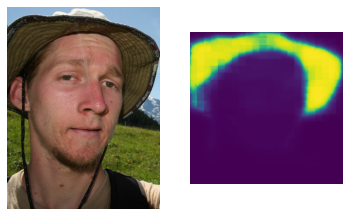

In [308]:
_, ax = plt.subplots(1, 1 + len(prompts))#, figsize=(15, len(prompts)))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(example["bbox_image"])
ax[1].imshow(torch.sigmoid(preds[:, 0, :]))
print(preds.shape)
# [ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
# [ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [306]:
# save to temporary file
import tempfile
  
# temp = tempfile.TemporaryFile()
temp = "temp.jpg"
plt.imsave(temp, torch.sigmoid(preds[:, 0, :]))

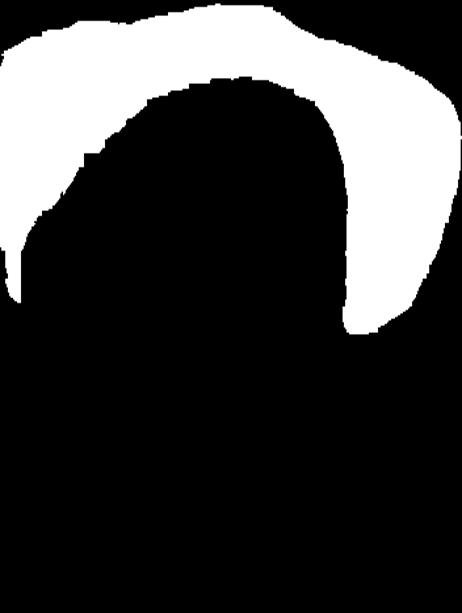

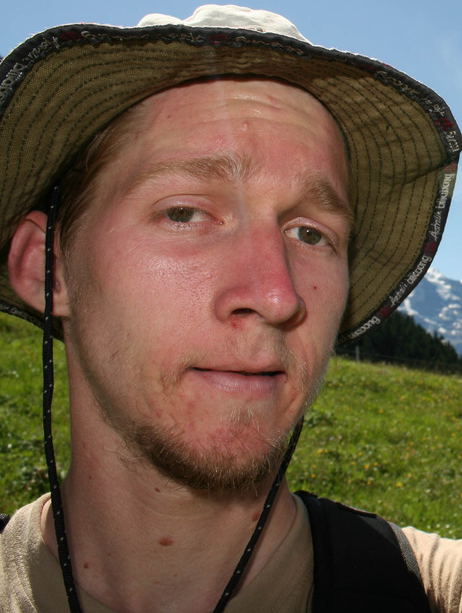

In [307]:
import cv2
from PIL import Image

img2 = cv2.imread(str(temp))

gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 90, 255, cv2.THRESH_BINARY)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

# Image.fromarray(bw_image)

# resize to original bbox image size
display(Image.fromarray(bw_image).resize(example["bbox_image"].size))
display(example["bbox_image"])

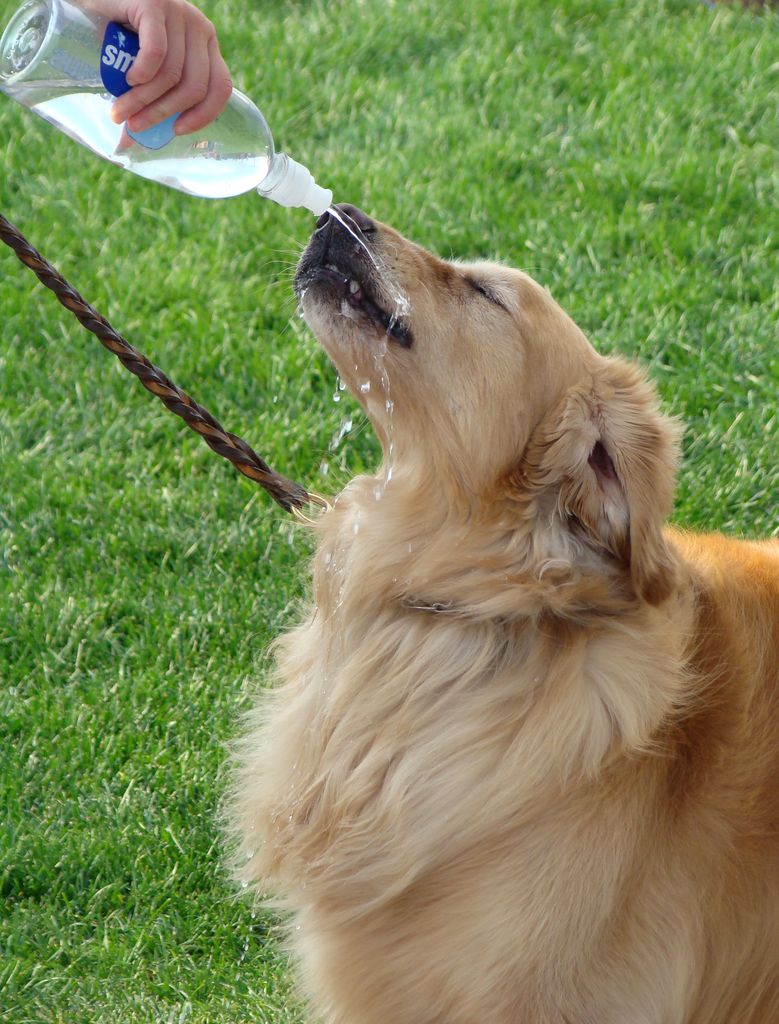

'an image of a dog being fed water by the owner, the dog is'

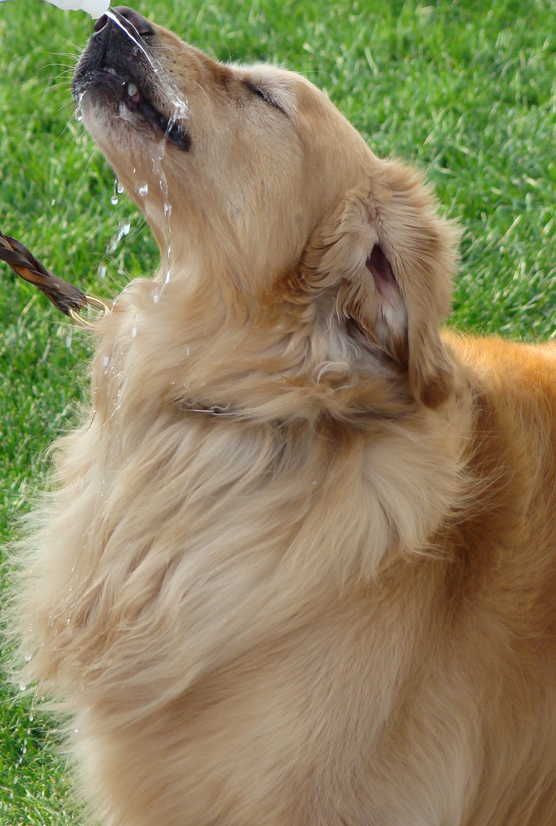

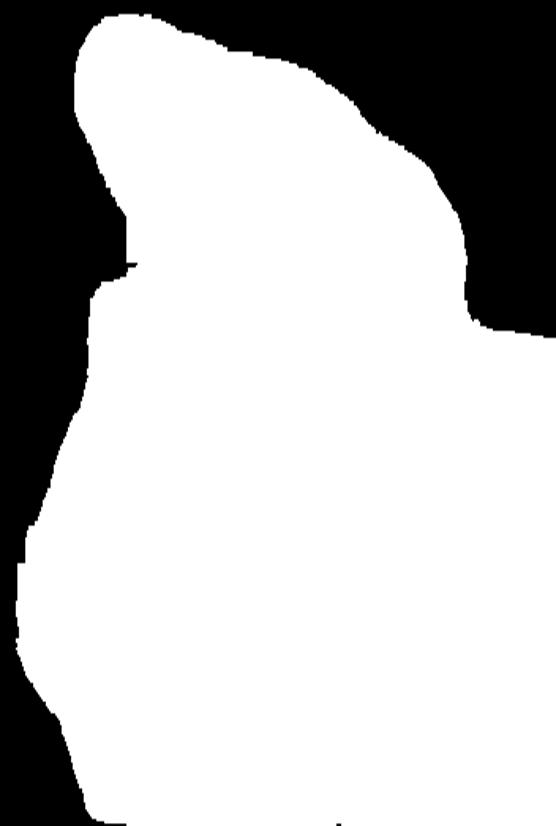

In [388]:
import os

i = random.randint(0, len(dataset))

example = dataset[i]

mask_root = "/export/home/workspace/dreambooth/diffusers/data/openimage-mask/train"
mask_filename = f"{example['image_id']}_{example['class_name']}.jpg"
mask_img = Image.open(os.path.join(mask_root, mask_filename))

display(example["image"])
display(example["caption"])
display(example["bbox_image"])
display(mask_img)